In [1]:
import biosignalsnotebooks as bsnb
from numpy import linspace, diff, zeros_like, arange, array
from scipy import signal
from scipy.signal import correlate
import scipy as sp
from scipy.signal import find_peaks
import math
from scipy import signal as scisig
import neurokit2 as nk
import statistics
import math

from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from scipy.stats import zscore

In [2]:
%run "3.0 - Functions_peakdetection.ipynb"

# 1) HRV Extraction functions
## 1.1) R-R extraction

In [4]:
def RR_calculator(peaks):
    """ This function aims to calculate the R_R intervals, apply some correction, and plot the R-R intervals vs time (ms)
    Input: Dataframe called peaks read from Peaks feather file. Columns in the file are 'x_values' which hold the time for which the peak was detected.
    Output: Dataframe called RR_data. Columns in RR_data are: 
        'x_values' -> the time values of the first peak in the R-R interval
        'R-R Interval Raw' -> The RR intervals calculated directly from the peaks
        'R-R Interval Final' -> The normalised RR intervals after some outliers have been removed   
    """
    
    #Defining and initializing data structures
    x_values = peaks['x_values'].values #Taking the x values of the peaks and putting them in an array
    RR = []                            #Creating an array to the store the corresponding R_R intervals
    RR_data = pd.DataFrame(columns=['x_values','R-R Interval Raw', 'R-R Interval Final']) #Creating a dataframe to store the R_R intervals along their position
    
    #R-R interval calculation
    for index, value in enumerate(x_values): # The for loop ends if the index values get bigger than the array itself.
        if index+1 == len(peaks) :
            break
        diff = x_values[index+1]-x_values[index]
        RR.append(diff)

    RR_data['x_values']= x_values[0:len(x_values)-1] #Storing the x values and the raw R-R intervals in the data frame
    RR_data['R-R Interval Raw']= RR 
    #Processing the raw R-R interval data by removing the mean, applying a sliding window, and removing the outliers
    RR_mean = np.mean(RR) #Mean removal
    RR = RR-RR_mean
 
    RR_final = []
            
# The values that are found to be two standard deviations from the mean are changed by the mean value of the window.
    RR_std = statistics.stdev(RR)
    for index, value in enumerate(RR):
        if value > (RR_mean+2*RR_std):
            RR_final.append(RR_mean + 2*RR_std)
        elif value < -(RR_mean +2*RR_std):
            RR_final.append(-(RR_mean+ 2*RR_std))
        else:
            RR_final.append(value)
    

    RR_final=np.array(RR_final) 
    
    RR_data['R-R Interval Final']= RR_final  #Storing the final R-R interval data in the data frame
    #RR_data = IQR(RR_data,'R-R Interval Final')
    #Plotting the final R_R interval vs x
    #plt.plot(RR_data['x_values'], RR_data['R-R Interval Final'])
    #plt.xlabel('Time (ms)')
    #plt.ylabel('R-R Interval')
    #plt.show()

    return RR_data


In [20]:
def _outlier_removal(hrv):
    """
    Inputs
    hrv: dataframe extracted from the RR_calculation function.
    Outputs
    rr: dataframe with the x_values and RR intervals as columns with the outliers removed from the dataframe.
    """
    rr = hrv
    z_scores = sp.stats.zscore(rr)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis=1)
    index_values = []
    for index,value in enumerate(filtered_entries):
        if value == False:
            index_values.append(index)
    rr = rr.drop(index_values)
    return rr
    

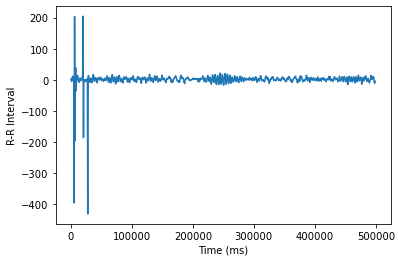

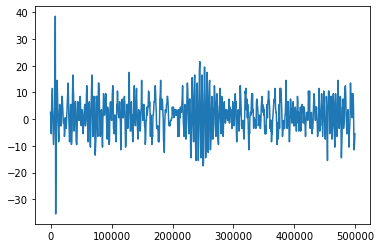

In [32]:
ecg100 = nk.ecg_simulate(duration=500, sampling_rate=1000, heart_rate=100, noise=0.2) # No noise, HR:100
peaks = _filteringdet(ecg100,1000)
hrv = RR_calculator(peaks)
rr = _outlier_removal(hrv)
plt.plot(rr['x_values'],rr['R-R Interval Final'])
plt.show()

# 1) Time domain HRV parameters:
## 1.1) R-R intervals

## 1.2) SDNN

In [6]:
#This function aims to calculate SDNN (standard deviation of intervals) and SDNNI (mean of the standard deviation of intervals)
def SDNN_calculator(RR_data):
    x_values = RR_data['x_values'].values
    RR = RR_data['R-R Interval Final'].values
    
    SDNN = np.std(RR)
    print('The SDNN is', SDNN)
    
    return SDNN

## 1.3) RMSSD

In [7]:
#This function aims to calculate RMSSD (Root Mean Square of Successive Differences)
def RMSSD_calculator(RR_data):
    x_values = RR_data['x_values'].values
    RR = RR_data['R-R Interval Final'].values
    sq_diff=[]
    
    for index, value in enumerate(RR): # The for loop ends if the index values get bigger than the array itself
        if index+1 == len(RR) :
            break
        diff = RR[index+1]-RR[index]   
        sq_diff.append(diff**2)      #Calculate the squared difference and append it to an array
    
    sq_diff = np.array(sq_diff)
    RMSSD = math.sqrt(np.mean(sq_diff))  #Calculate the root square of the mean of the squared differences
    print('The RMSSD is', RMSSD)
    
    return RMSSD

## 1.4) PNN50

In [8]:
#This function aims to calculate PNN50 (The percentage of adjacent NN intervals that differ from each other by more than 50 ms)
def PNN50_calculator(RR_data):
    x_values = RR_data['x_values'].values
    RR = RR_data['R-R Interval Final'].values
    counter=0 
    
    for index, value in enumerate(RR): # The for loop ends if the index values get bigger than the array itself.
        if index+1 == len(RR) :
            break
        diff = RR[index+1]-RR[index]
        if (diff>50):
            counter = counter +1
    
    PNN50= (counter/len(RR))*100
    print('The PNN50 is', PNN50, '%')
    
    return PNN50

# 2) Frequency domain parameters
## 2.1) Resampling the signal

In [9]:
def resample(RR_data , freq):
    """ This function aims to resample the signal with a known sampling rate for further frequency domain analysis
    Input: RR_data from the RR_Calculator function and a frequency (freq) for resampling the cubic spline.
    Output: Dataframe called new_RR_data. Columns in new_RR_data are: 
        'x_values' -> the time values of the resampled section
        'R-R Interval' -> The new resampled 'R-R Interval Final' 
    """
    new_RR_data = pd.DataFrame()
    
    # Interpolate with a cubic spline
    x_values = RR_data['x_values'].values
    interpol = interp1d(x_values, RR_data['R-R Interval Final'], kind='cubic')
    
    #Calculate the number of samples we want and resample
    num = int(np.max(x_values)*freq/1000) #Length of the signal * frequency to get total number of samples
    new_RR = scipy.signal.resample(interpol(x_values), num) #function is interpol(x_values), num is the number of new samples
    
    #period = 1000/freq #in ms
    
    # Some checks
#     print(period)
#     print(len(new_RR))
#     print(len(np.arange(np.min(x_values), np.max(x_values), period)))

    # Assigning values to new dataFrame
    new_RR_data['R-R Interval Final'] = new_RR
    new_RR_data['x_values'] = np.linspace(np.min(x_values), np.max(x_values), num = num) #Set equally spaced x-axis between beginning and end of original x_values
    #np.arange(np.min(x_points), np.max(x_points), period)

    return new_RR_data

## 2.2) Fast Fourier Transform

In [10]:
def _fft(df,rate):
    """ Function definition for the Fast Fourier Transform and plotting the PSD of the signal.
    Input: Resampled new_RR_data from the resample function and a rate for the sampling rate used in the resample.
    Output: Dataframe called freq_values. Columns in freq_values are: 
        'Frequency' -> the frequencies 
        'Power' -> The power at each frequency 
    """
    # Initialisation
    freq_values = pd.DataFrame()
    time = df['x_values']
    hrv_signal = df['R-R Interval Final'].values

    # Number of samples in normalized_tone
    N = len(hrv_signal)

    # Calculating fourier transforms
    xf = rfftfreq(N, 1 / rate) # Returns the Discrete Fourier Transform sample frequencies
    yf = np.abs(rfft(hrv_signal)) # Computes the one-dimensional discrete Fourier Transform for real input.
    
    # Plotting Frequency Domain HRV values
    plt.plot(xf, yf)
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Power(ms^2)')
    
    #HF - 0.15-0.4, LF - 0.04-0.15
    plt.axvline(x=0.040, color='k')
    plt.axvline(x=0.15, color='r')
    plt.axvline(x=0.40, color='b')
    plt.xlim([0, 0.5])
    #plt.title('PSD Healthy Patient')
    #plt.show()
    
    # Save values in new data_frame
    freq_values['Frequency'] = xf
    freq_values['Power'] = yf
    return freq_values

## 2.2) High, Low and High/Low Frequency Band Powers

In [11]:
def _HFpow(freq_values):
    """Finds and returns the absolute power of the High Frequency band (0.15-0.4Hz)
    Input: freq_values - DataFrame of frequency domain HRV values obtained from the fft.
    Output: Absolute power of high frequency band, float
    """
    
    # Select Only the High frequency band
    HF = freq_values.loc[(freq_values['Frequency'] > 0.15) &  (freq_values['Frequency'] < 0.4)]
    HF = HF.reset_index(drop = True)

    # Delta of integration, gap between neigbouring frequency points
    width = (HF.iloc[1]['Frequency'] - HF.iloc[0]['Frequency'])
    
    #'Integrate' the HF band to get absolute power
    HFpow = 0
    for index, row in HF.iterrows():
        HFpow += HF.iloc[index]['Power'] * width
        
    print("New formula being used")
    print('The absolute power of the High Frequency band is', HFpow)
    return HFpow

In [12]:
def _LFpow(freq_values):
    """Finds and returns the absolute power of the Low Frequency band (0.04-0.15Hz)
    Input: freq_values - DataFrame of frequency domain HRV values obtained from the fft.
    Output: Absolute power of high frequency band, float
    """
    
    # Select Only the Low frequency band
    LF = freq_values.loc[(freq_values['Frequency'] > 0.04) &  (freq_values['Frequency'] < 0.15)]
    LF = LF.reset_index(drop = True)
    
    # Delta of integration, gap between neigbouring frequency points
    width = (LF.iloc[1]['Frequency'] - LF.iloc[0]['Frequency'])
    
    #'Integrate' the LF band to get absolute power
    LFpow = 0
    for index, row in LF.iterrows():
        LFpow += LF.iloc[index]['Power'] * width
        
    print('The absolute power of the Low Frequency band is', LFpow)
    return LFpow

In [13]:
def _LFHF(freq_values):
    """Finds and returns the ratio of Low Frequency to High Frequency band powers
    Input: freq_values - DataFrame of frequency domain HRV values obtained from the fft.
    Output: Absolute power of high, low frequency bands and their ratio, all floats
    """
    LF = _LFpow(freq_values)
    HF = _HFpow(freq_values)
    LFHF = LF/HF
    print('The LF/HF is', LFHF)
    return LF, HF, LFHF

# 3) Testing the HRV extraction functions with synthetic data

In [14]:
# #Testing the functions with synthetic data that has already successfully passed the peak detection
# # We generate three different synthethic ECG signals. Library: neurokit2

# ecg50 = nk.ecg_simulate(duration=300, sampling_rate=1000, heart_rate=50) # No noise, HR:50
# ecg80 = nk.ecg_simulate(duration=300, sampling_rate=1000, heart_rate=80) # No noise, HR:80
ecg100 = nk.ecg_simulate(duration=300, sampling_rate=1000, heart_rate=100) # No noise, HR:100

In [15]:
 #Plotting the signals 


# #Filtering the signals and plotting them in each step of the process
# peaks = _filteringdet(ecg50,1000)

# #Detecting the peaks and plotting them
# # plt.plot(ecg50)
# # plt.scatter(peaks['x_values'],peaks['y_values'], marker='o', color='r')
# # plt.ylabel("Amplitude(mV)")
# # plt.xlabel("Time (ms)")
# # plt.title("Peaks Detected On Original Signal")
# # plt.show()

# #Calculate the time domain HRV parameters 
# RR_data = _hrvreading(peaks)  #Calculating RR intervals
# SDNN =  SDNN_calculator(RR_data) #Calculating the SDNN parameter
# RMSSD = RMSSD_calculator(RR_data) #Calculating the RMSSD parameter
# PNN50 = PNN50_calculator(RR_data) #Calculating the PNN50 parameters

# freq_data = _fft(RR_data, 1000)
# LFHF = _LFHF(freq_data) #Calculating the frequency parameters


In [16]:
# peaks = _filteringdet(ecg80,1000)

# #Calculate the time domain HRV parameters 
# RR_data = _hrvreading(peaks)  #Calculating RR intervals
# SDNN =  SDNN_calculator(RR_data) #Calculating the SDNN parameter
# RMSSD = RMSSD_calculator(RR_data) #Calculating the RMSSD parameter
# PNN50 = PNN50_calculator(RR_data) #Calculating the PNN50 parameters

# freq_data = _fft(RR_data, 1000)
# LFHF = _LFHF(freq_data) #Calculating the frequency parameters

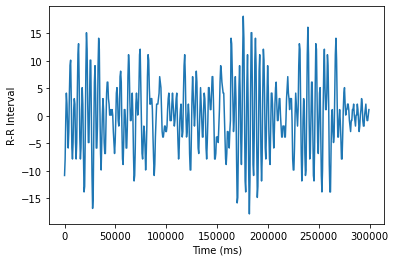

The SDNN is 6.341695356921523
The RMSSD is 5.024189981473619
The PNN50 is 0.0 %
The absolute power of the Low Frequency band is 9416.60604166856
New formula being used
The absolute power of the High Frequency band is 14774.9107327605
The LF/HF is 0.6373375928958448


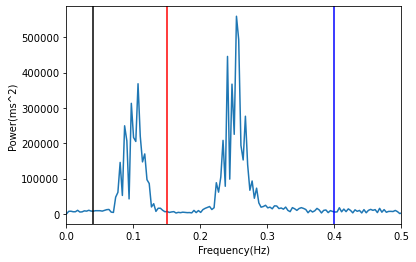

In [17]:
peaks = _filteringdet(ecg100,1000)

#Calculate the time domain HRV parameters 
RR_data = RR_calculator(peaks)  #Calculating RR intervals
SDNN =  SDNN_calculator(RR_data) #Calculating the SDNN parameter
RMSSD = RMSSD_calculator(RR_data) #Calculating the RMSSD parameter
PNN50 = PNN50_calculator(RR_data) #Calculating the PNN50 parameters

freq_data = _fft(resample(RR_data, 1000), 1000)
LFHF = _LFHF(freq_data) #Calculating the frequency parameters

In [18]:
#Testing the functions with synthetic data that has already successfully passed the peak detection
# We generate three different synthethic ECG signals. Library: neurokit2

#ecg50 = nk.ecg_simulate(duration=300, sampling_rate=1000, heart_rate=50) # No noise, HR:50
ecg80 = nk.ecg_simulate(duration=300, sampling_rate=1000, heart_rate=80) # No noise, HR:80
# ecg100 = nk.ecg_simulate(duration=300, sampling_rate=1000, heart_rate=100) # No noise, HR:100

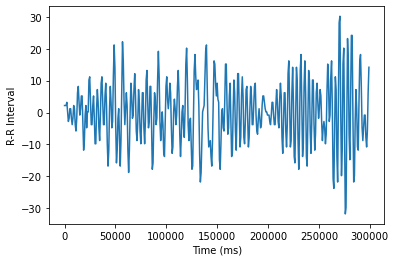

400


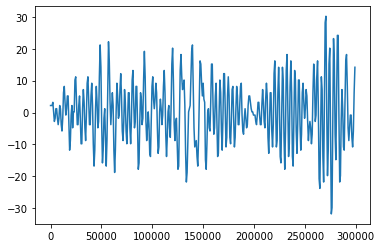

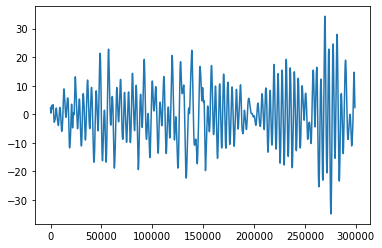

In [19]:
peaks = _filteringdet(ecg80,1000)
RR_data = RR_calculator(peaks)
RR_data.head()
print(len(RR_data))

plt.plot(RR_data['x_values'], RR_data['R-R Interval Final'])
plt.show()

resampled = resample(RR_data, 100)
resampled.head()
plt.plot(resampled['x_values'], resampled['R-R Interval Final'])
plt.show()


#ff = _fft(resampled, 100)